# Reading Annotaions

In [1]:
import re
import numpy as np
from scipy.optimize import least_squares

# Function to safely parse coordinate data
def parse_coordinates(coord_string):
    try:
        coordinates = eval(coord_string)
        if isinstance(coordinates, list) and all(isinstance(coord, tuple) for coord in coordinates):
            return coordinates
    except:
        return []

# Function to parse a line
def parse_line(line):
    # Use regex to split line while ignoring commas within square brackets
    parts = re.split(r',(?![^\[\]]*\])', line.strip())

    if len(parts) < 6:
        return None, 'Insufficient data'

    try:
        active = int(parts[0])
        index = int(parts[1])
        data_type = int(parts[2])
        coordinates = parse_coordinates(parts[3])
        colour = parts[4]
        fixed_value = int(parts[5])
    except ValueError as e:
        return None, str(e)

    return {
        'Active': active,
        'Index': index,
        'Type': data_type,
        'Coordinates': coordinates,
        'Color': colour,
        'Fixed Value': fixed_value
    }, None

# Main function to read and categorize data
def read_and_categorize(file_path):
    categorized_data = []
    error_count = 0

    try:
        with open(file_path, 'r') as file:
            for line in file:
                parsed_data, error = parse_line(line)
                if parsed_data:
                    categorized_data.append(parsed_data)
                elif error:
                    print(f"Skipping line due to parsing error: {line}. Error: {error}")
                    error_count += 1
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

    return categorized_data, error_count

# Known points in the first image (width = 10511)
p1_old = np.array([0.18319558536996872 * 10511, 0.4175176958359143 * 10511])
p2_old = np.array([0.44720853752805334 * 10511, 0.6815269638613446 * 10511])

# Known points in the second image (width = 16384)
p1_new = np.array([0.2964984303713581 * 16384, 0.20486673050157883 * 16384])
p2_new = np.array([0.4660897028652409 * 16384, 0.37439425586304204 * 16384])

# Function to model the affine transformation
def affine_transform(params, src, dst):
    a, b, tx, ty = params
    transformed = np.dot(np.array([[a, -b], [b, a]]), src.T).T + [tx, ty]
    return (transformed - dst).ravel()

# Initial guess for the parameters
initial_params = [1, 0, 0, 0]

# Solve for the transformation parameters
result = least_squares(affine_transform, initial_params, args=(np.array([p1_old, p2_old]), np.array([p1_new, p2_new])))
a, b, tx, ty = result.x

# Define the affine transformation matrix
transformation_matrix = np.array([[a, -b, tx], [b, a, ty]])

# Function to apply the affine transformation to a point
def apply_affine_transform(point, matrix):
    point_homogeneous = np.append(point, 1)  # Convert to homogeneous coordinates
    transformed_point = np.dot(matrix, point_homogeneous)
    return transformed_point[:2]

# Function to transform all coordinates in the categorized data
def transform_coordinates(categorized_data, width1, width2, matrix):
    for data in categorized_data:
        new_coordinates = []
        for coord in data['Coordinates']:
            point = np.array([coord[0] * width1, coord[1] * width1])
            transformed_point = apply_affine_transform(point, matrix)
            new_normalized = (transformed_point[0] / width2, transformed_point[1] / width2)
            new_coordinates.append(new_normalized)
        data['Coordinates'] = new_coordinates
    return categorized_data

# Read and categorize data
file_path = f'/rsrch5/home/plm/yshokrollahi/project4/RawDataset/annotaions/MS023S1.txt'
categorized_data, error_count = read_and_categorize(file_path)

# Transform coordinates
width1 = 10511
width2 = 16384
transformed_data = transform_coordinates(categorized_data, width1, width2, transformation_matrix)

# Output the transformed data
for data in transformed_data:
    print(data)

if not categorized_data and error_count == 0:
    print("No data was parsed successfully.")
else:
    print(f"Total number of parsing errors: {error_count}")


{'Active': 1, 'Index': 1, 'Type': 6, 'Coordinates': [(0.6088148780422266, 0.056237144393517555), (0.6088148780422266, 0.056237144393517555)], 'Color': '#00ffff', 'Fixed Value': 1}
{'Active': 1, 'Index': 2, 'Type': 6, 'Coordinates': [(0.6089845965073459, 0.07323458766049008), (0.6089845965073459, 0.07323458766049008)], 'Color': '#00ffff', 'Fixed Value': 1}
{'Active': 1, 'Index': 3, 'Type': 6, 'Coordinates': [(0.5744845942568831, 0.06212831536897169), (0.5744845942568831, 0.06212831536897169)], 'Color': '#00ffff', 'Fixed Value': 1}
{'Active': 1, 'Index': 4, 'Type': 6, 'Coordinates': [(0.581927640724358, 0.06051609644849534), (0.581927640724358, 0.06051609644849534)], 'Color': '#00ffff', 'Fixed Value': 1}
{'Active': 1, 'Index': 5, 'Type': 6, 'Coordinates': [(0.5749296563291395, 0.06590545125344864), (0.5749296563291395, 0.06590545125344864)], 'Color': '#00ffff', 'Fixed Value': 1}
{'Active': 1, 'Index': 6, 'Type': 6, 'Coordinates': [(0.5701509397533069, 0.05679655890864231), (0.57015093975

In [2]:

categorized_data = transformed_data
cd = 0
panck = 0
others = 0
cd_less = 0
for i in range(len(categorized_data)):
    if categorized_data[i]['Color'] == "#00ffff" or categorized_data[i]['Color'] == "#0000ff":
        cd += 1
    elif categorized_data[i]['Color'] == '#c0c0c0':
        cd_less += 1
    elif categorized_data[i]['Color'] == '#ff00ff':
        panck += 1
    else:
        others += 1

In [3]:
print('cd45+ 95%: ' + str(cd))
print('cd45+ 70%: ' + str(cd_less))
print('panck: ' + str(panck))
print('others: ' + str(others))

cd45+ 95%: 1479
cd45+ 70%: 341
panck: 2064
others: 1133


In [4]:
points_normalized = []
points_colors = []
for i in range(len(categorized_data)):
    points_normalized.append(categorized_data[i]['Coordinates'][0])
    points_colors.append(categorized_data[i]['Color'])  # Extracting color

    
max(points_normalized, key=lambda x:x[0])


(0.74431595279047, 0.23103855790657446)

all points: 5017
 points shown: 5017


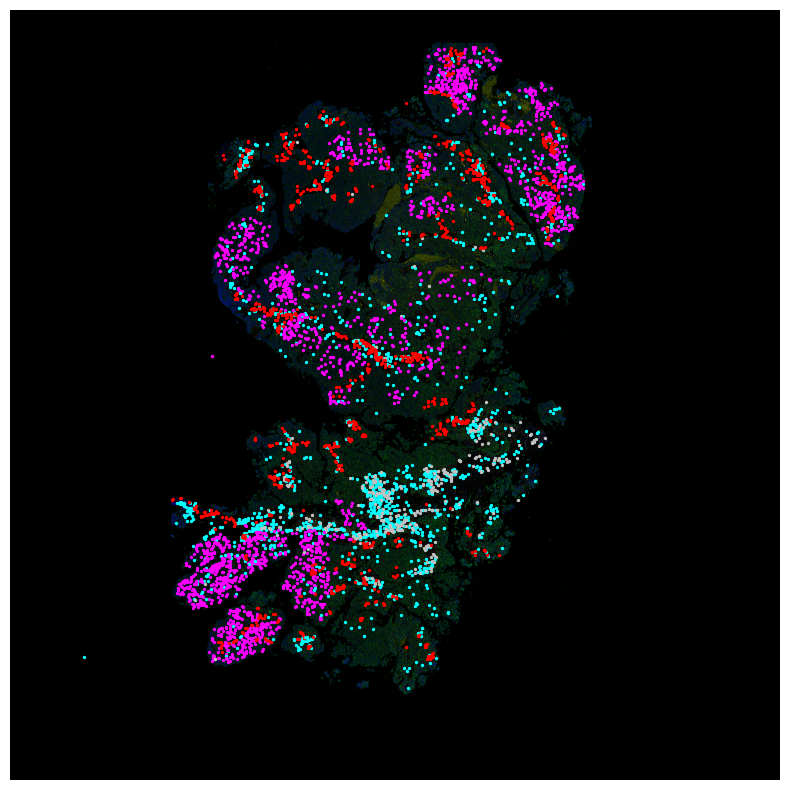

In [7]:
import cv2
import matplotlib.pyplot as plt

# Path to your image
root = "/rsrch5/home/plm/yshokrollahi/project4/RawDataset/"
image_path = f"{root}/ome-png/MS023S1.png"
# Load the image using OpenCV
image = cv2.imread(image_path)

# Get the width and height of the image
height, width, _ = image.shape

# Lists to hold normalized points (x, y) and their respective colors
points_normalized = []
points_colors = []

# Extract coordinates and colors from categorized_data
for i in range(len(categorized_data)):
    points_normalized.append(categorized_data[i]['Coordinates'][0])
    points_colors.append(categorized_data[i]['Color'])  # Extracting color

# Convert normalized coordinates to pixel values
points_pixel = [(int(x * width), int(y * width)) for x, y in points_normalized]

plt.figure(figsize=(10, 10))

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

print(f'all points: {len(points_pixel)}')
points_shown = 0

# Plot the points on the image with their respective colors
for (x, y), color in zip(points_pixel, points_colors):
    plt.scatter(x, y, c=color, marker='o', s=2)  # Using extracted color for each point
    points_shown += 1

print(f' points shown: {points_shown}')

plt.axis("off")
# plt.savefig("/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/ROIs/28/MS028S1.png")    
# Show the image with points
plt.show()


# Save annotaions vs patches

In [15]:
import os
import cv2
import numpy as np

# Function to create patches and save images and annotations
def create_patches_and_save_annotations(image_path, annotations, patch_size=640, output_folder="output"):
    # Ensure output directories exist
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(os.path.join(output_folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_folder, "annotations"), exist_ok=True)

    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    # Function to get label from color
    def get_label_from_color(color):
        if color == '#00ffff' or color == '#0000ff':
            return '0'
        elif color == '#ff00ff':
            return '1'
        else:
            return '2'

    patch_idx = 1

    for y in range(0, img_height, patch_size):
        for x in range(0, img_width, patch_size):
            # Handle overlap for last row and column
            if y + patch_size > img_height:
                y = img_height - patch_size
            if x + patch_size > img_width:
                x = img_width - patch_size
            
            # Extract patch
            patch = image[y:y+patch_size, x:x+patch_size]

            # Extract annotations for the patch
            patch_annotations = []
            for annotation in annotations:
                for coord, color in zip(annotation['Coordinates'], [annotation['Color']]):
                    coord_x = coord[0] * img_width
                    coord_y = coord[1] * img_width
                    if x <= coord_x < x + patch_size and y <= coord_y < y + patch_size:
                        local_x = coord_x - x
                        local_y = coord_y - y
                        label = get_label_from_color(color)
                        patch_annotations.append((label, local_x, local_y))
            
            # Only save the patch and annotations if there are annotations available
            if patch_annotations:
                patch_filename = f"patch_{patch_idx}.png"
                patch_filepath = os.path.join(output_folder, "images", patch_filename)
                cv2.imwrite(patch_filepath, patch)

                patch_annotation_filename = f"patch_{patch_idx}.txt"
                patch_annotation_filepath = os.path.join(output_folder, "annotations", patch_annotation_filename)
                with open(patch_annotation_filepath, 'w') as f:
                    for label, local_x, local_y in patch_annotations:
                        f.write(f"{label} {local_x / patch_size} {local_y / patch_size} {50 / patch_size} {50 / patch_size}\n")

                patch_idx += 1

# Example usage
image_path = f"{root}/ome-png/MS023S1.png"  # Replace with your image path
output_folder = f"{root}/ome-png/23_patches/"  # Replace with your output folder path

# Use the already transformed data (assuming transformed_data is the output from the previous cell)
create_patches_and_save_annotations(image_path, transformed_data, patch_size=640, output_folder=output_folder)


# verfiy

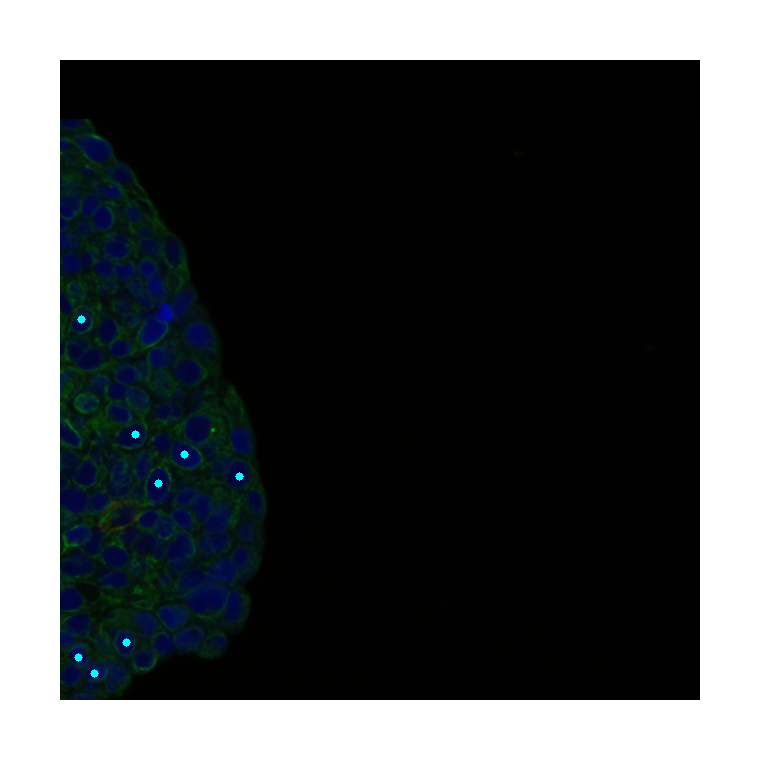

In [20]:
import cv2
import matplotlib.pyplot as plt
i = 4
image_path = f"{root}/ome-png/23_patches/images/patch_{i}.png"
image = cv2.imread(image_path)

# Get image dimensions (height, width)
height, width, channels = image.shape

# Convert image dimensions from pixels to inches for matplotlib (figure size in inches)
dpi = 600  # You can adjust this value to increase or decrease the image quality
figsize = width / float(dpi), height / float(dpi)

text_file_path = f"{root}/ome-png/23_patches/annotations/patch_{i}.txt"

colors = {
    '0': (0, 0, 255),
    '1': (255, 255, 0),
    '2': (255, 0, 255)
}

with open(text_file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    values = line.strip().split(' ')
    if len(values) == 5:
        label, x_center, y_center, width, height = map(float, values)

        image_width, image_height = 640, 640

        x_center *= image_width
        y_center *= image_height

        color = colors.get(str(int(label)), (0, 0, 255))

        cv2.circle(image, (int(x_center), int(y_center)), radius=4, color=color, thickness=-1)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a figure with the specified size and DPI
plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.tight_layout(pad=0)  # Remove whitespace

# Specify your save path
# save_path = f'/Users/yshokrollahi/Desktop/MD/Project3/dataset/IF/ROIs/Validation_By_Pathologist/Maria/{name}/prediction/{name}_PATCH_{patch}.png'
# plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=dpi)

# Optionally, you can still display the image in the notebook with plt.show()
# plt.show()
